### Data Preparation

We need to import several packages first.

In [ ]:
import sys, os, re, json
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from collections import defaultdict, Counter
from typing import List, Tuple, Dict
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

In [ ]:
%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Here are some file paths.

In [ ]:
# Read the training data
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
df1 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/amazondata.csv")
df2 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Flipcartdata.csv")
df_review = pd.concat([df1, df2], axis=0)
df_review

Mounted at /content/gdrive


text  stars
0     You will love this book.  It is a hard long re...    5.0
1     This is the UK edition of Dr. Omit's book. Dr....    NaN
2     This is a fun and entertaining book about lear...    5.0
3     Started a big slow, but once into it the autho...    5.0
4     Received this book as a Christmas present. I h...    4.0
...                                                 ...    ...
9971                                      GoodREAD MORE    5.0
9972  Everything is amazimg but the built is very li...    5.0
9973                                      GoodREAD MORE    5.0
9974       Best headphone i have ever used....READ MORE    5.0
9975                                      NiceREAD MORE    5.0

[138821 rows x 2 columns]

In [ ]:
df_review.shape

(138821, 2)

Some samples for reviews.

In [ ]:
df_review.head(10)

text  stars
0  You will love this book.  It is a hard long re...    5.0
1  This is the UK edition of Dr. Omit's book. Dr....    NaN
2  This is a fun and entertaining book about lear...    5.0
3  Started a big slow, but once into it the autho...    5.0
4  Received this book as a Christmas present. I h...    4.0
5  -If you wonder \Where did that promise of a pe...    NaN
6  Ugly Impostor, discernible face, self esteem r...    5.0
7  I agree with those reviewers that believe that...    2.0
8  Then I watch American Masters (PBS) featuring ...    5.0
9  I am a fan of all of Tepper's books.  I had be...    NaN

In [ ]:
# Drop the NaN values and adjust the indexing
df_review = df_review.dropna().reset_index(drop=True)

In [ ]:
# Text preprocessing
def preprocessing(user_reviews):
  review = BeautifulSoup(user_reviews).get_text() # Remove HTML tags
  review = re.sub("[^a-zA-Z]", " ", review) # Remove special characters
  review = review.lower().split() # Convert to lowercase and split each word

  stop_w = set(stopwords.words("english")) # Use a set instead of list for faster searching
  review = [w for w in review if not w in stop_w] # Remove stop words
  review = [WordNetLemmatizer().lemmatize(w) for w in review] # Lemmatization

  return (" ".join(review)) # Return the words after joining each word separated by space

In [ ]:
# Clean all reviews in the train set
clean_reviews = []
for i in range(0, df_review['text'].size):
  clean_reviews.append(preprocessing(df_review['text'][i]))

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.pianopedagogy.org/book-club-first-selection-the-success-factor-in-piano-teaching-making-practice-perfect-pearce/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/Ca%C3%ADda-Los-Gigantes-Spanish/dp/0307741184/ref=sr_1_sc_1?ie=UTF8&qid=1440887588&sr=8-1-spell&keywords=la+caidade+los+giganttes" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


### Data Distribution

We should rating distribution here.

In [ ]:
df_review["stars"].value_counts(normalize=False)

5.0       78974
4.0       24015
3.0       10940
1.0        6104
2.0        5495
          ...  
54.0          1
35.0          1
2008.0        1
58.0          1
190.0         1
Name: stars, Length: 71, dtype: int64

In [ ]:
def plot_labels(df, title=None):
  ds_labels = df["stars"].value_counts(normalize=True)
  ds_labels.sort_index(inplace=True)
  plt.figure(figsize=(4,3))
  ax = ds_labels.plot(kind="bar")
  ax.set_xlabel("Stars")
  ax.set_ylabel("Ratio")
  if title is not None:
    plt.savefig(title + ".eps")
  plt.show()

In [ ]:
plot_labels(df_review, "stars")

We can find that the dataset is imbalanced.

### Data Preprocessing and Split

We need to seperate training, validation, and testing sets.

* Training set: balanced dataset
* Validation/Testing set: raw (imbalanced) dataset

In [ ]:
from sklearn.model_selection import train_test_split

df_train_raw, df_test = train_test_split(df_review, test_size=15000, 
                                         random_state=42, shuffle=True)
df_train_raw, df_dev = train_test_split(df_train_raw, test_size=15000,
                                        random_state=42, shuffle=True)

In [ ]:
df_train_raw["stars"].value_counts(normalize=False)

5.0      60124
4.0      18323
3.0       8367
1.0       4633
2.0       4239
         ...  
33.0         1
40.0         1
119.0        1
43.0         1
152.0        1
Name: stars, Length: 64, dtype: int64

In [ ]:
from sklearn.utils import resample

def undersample(df, group_size=250000):
  dfs = []

  for label in df["stars"].value_counts().keys():
    df_group = df[df["stars"] == label]
    df_group_undersampled = resample(df_group, 
                                     replace=False, 
                                     n_samples=group_size, 
                                     random_state=0)
    dfs.append(df_group_undersampled)

  return pd.concat(dfs).sample(frac=1, random_state=0)

In [ ]:
df_train = df_train_raw

In [ ]:
num_review = df_review.shape[0]
num_train = df_train.shape[0]
num_dev = df_dev.shape[0]
num_test = df_test.shape[0]

(96275, 2)


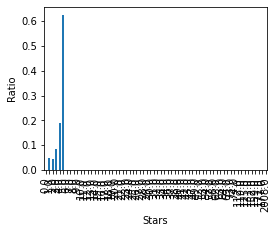

In [ ]:
print(df_train.shape)
plot_labels(df_train)

(15000, 2)


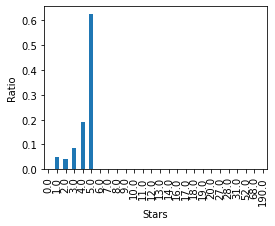

In [ ]:
print(df_dev.shape)
plot_labels(df_dev)

(15000, 2)


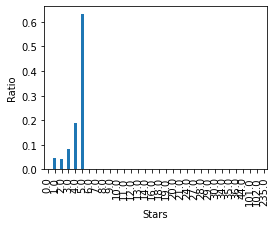

In [ ]:
print(df_test.shape)
plot_labels(df_test)

In [ ]:
df_train["labels"] = df_train["stars"] - 1
df_dev["labels"] = df_dev["stars"] - 1
df_test["labels"] = df_test["stars"] - 1

In [ ]:
df_train.head(10)

text  stars  labels
108184  this book has been very insightful on eating g...    5.0     4.0
40200   Another smash hit from the greatest thriller w...    5.0     4.0
121809                              Best headaetREAD MORE    5.0     4.0
93340   I found this heartfelt story very entertaining...    5.0     4.0
88060   In 1921 Widmerpool formed a concrete picture i...    5.0     4.0
66573                                               grest    5.0     4.0
80396   I have really gotten a lot of use out of this ...    4.0     3.0
27579   Review of &#34;Winston's War:  I found this bo...    5.0     4.0
65748                          Great book.  Great author.    5.0     4.0
795     Interesting take on 9/11 and the politics behi...    5.0     4.0

## Feature Engineering

### Tokenization

In this part, we will tokenize reviews and count numbers of tokens for each review. This information will be useful in BERT model. But we will not use these tokens directly for training models.

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
ds_temp = df_train["text"].iloc[:10].map(lambda text: re.sub(r"[^a-zA-Z0-9' ]", ' ', text)).map(lambda text: text.split())
print(df_train["text"].iloc[0], '\n', ds_temp.iloc[0])

this book has been very insightful on eating good and healthy foods. It's an easy read and motivates me to make healthier choices! 
 ['this', 'book', 'has', 'been', 'very', 'insightful', 'on', 'eating', 'good', 'and', 'healthy', 'foods', "It's", 'an', 'easy', 'read', 'and', 'motivates', 'me', 'to', 'make', 'healthier', 'choices']


In [ ]:
%time df_train["tokens"] = df_train["text"].map(lambda text: re.sub(r"[^a-zA-Z0-9' ]", ' ', text)).map(lambda text: text.split())

CPU times: user 1.5 s, sys: 331 ms, total: 1.83 s
Wall time: 1.82 s


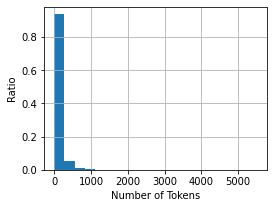

In [ ]:
df_train["num_tokens"] = df_train["tokens"].map(len)
ax = df_train["num_tokens"].hist(bins=20, 
                                 figsize=(4,3),
                                 weights=np.ones(num_train)/num_train)
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Ratio")
plt.show()

In [ ]:
print(len(df_train[df_train["num_tokens"] <= 128]) / len(df_train["num_tokens"]))
print(len(df_train[df_train["num_tokens"] <= 256]) / len(df_train["num_tokens"]))

0.8033549727343547
0.9247468190080499


In [ ]:
df_train.drop(columns=["tokens", "num_tokens"], inplace=True)

In [ ]:
%time df_review["num_tokens"] = df_review["text"].\
map(lambda text: re.sub(r"[^a-zA-Z0-9' ]", ' ', text)).\
map(lambda text: len(text.split()))

CPU times: user 1.4 s, sys: 12.9 ms, total: 1.41 s
Wall time: 1.4 s


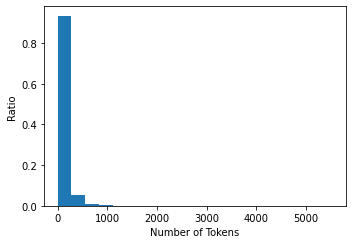

In [ ]:
ax = df_review["num_tokens"].hist(bins=20,
                                  figsize=(5,3.5),
                                  grid=False,
                                  weights=np.ones(num_review)/num_review)
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Ratio")
plt.savefig("num_tokens.eps")
plt.tight_layout()
plt.show()

In [ ]:
print(len(df_review[df_review["num_tokens"] <= 128]) / len(df_review["num_tokens"]))
print(len(df_review[df_review["num_tokens"] <= 256]) / len(df_review["num_tokens"]))

0.8036032468818056
0.9251237378736884


In [ ]:
df_review.drop(columns=["num_tokens"], axis=1, inplace=True)

From the result, we can see most reviews are shorter than 256 tokens.

### Vectorization

We will try following settings for vectorization.

* Word representation: `CountVectorizer` vs. `TfidfVectorizer`
* N-grams: unigram & bigram
* Minimum document frequency: 5
* Convert to lowercase
* Use stop words
* Try binary counter

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def extract_features(df_train, df_dev, df_test):
  vectorizer = TfidfVectorizer(analyzer='word', 
                               stop_words='english',
                               ngram_range=(1, 2),
                               lowercase=True,
                               min_df=5,
                               binary=False)
  X_train = vectorizer.fit_transform(df_train["text"])
  X_dev = vectorizer.transform(df_dev["text"])
  X_test = vectorizer.transform(df_test["text"])
  y_train = df_train["stars"].tolist()
  y_dev = df_dev["stars"].tolist()
  y_test = df_test["stars"].tolist()
  
  return X_train, X_dev, X_test, y_train, y_dev, y_test

In [ ]:
%time X_train, X_dev, X_test, y_train, y_dev, y_test = extract_features(df_train, df_dev, df_test)

CPU times: user 16.5 s, sys: 475 ms, total: 17 s
Wall time: 16.9 s


#### Test for CountVectorizer (Binary)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [ ]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.3min finished


LogisticRegression(C=5.0, class_weight='balanced', n_jobs=-1, random_state=0,
                   verbose=1)

In [ ]:
#evaluate_model(clf_lr, model_name="lr", model_name="lr_count_bin")

#### Test for CountVectorizer (Integer)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [ ]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.2min finished


LogisticRegression(C=5.0, class_weight='balanced', n_jobs=-1, random_state=0,
                   verbose=1)

In [ ]:
#evaluate_model(clf_lr, model_name="lr_count_int")

#### Test for TfidfVectorizer (Binary)

In [ ]:
X_train[:10,:]

<10x104760 sparse matrix of type '<class 'numpy.float64'>'
	with 225 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [ ]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.3min finished


LogisticRegression(C=5.0, class_weight='balanced', n_jobs=-1, random_state=0,
                   verbose=1)

In [ ]:
#evaluate_model(clf_lr, model_name="lr_tfidf_bin")

#### Test for TfidfVectorizer (Integer)

In [ ]:
X_train[:10,:]

<10x104760 sparse matrix of type '<class 'numpy.float64'>'
	with 225 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [ ]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
#evaluate_model(clf_lr, model_name="lr_tfidf_int")

## Experiments and Results

We will use machine learning models and transformer-based models.

### Machine Learning

Navie Bayes, Logistic Regression, Random Forest, and Linear SVM will used in this section.

#### Evaluation Metrics

* Precision, recall, F1 score
* Accuracy
* Confusion matrix

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [ ]:
def evaluate_model_Xy(model, X, y, y_pred=None, label="Training", model_name="model"):
  if y_pred is None:
    y_pred = model.predict(X)

  print(label + ' Set')
  print("Accuracy:", accuracy_score(y, y_pred))
  print()

  print(classification_report(y, y_pred, digits=4))
  disp = plot_confusion_matrix(model, X, y, 
                               cmap=plt.cm.Blues, normalize='true')
  plt.savefig(model_name + "_" + label.lower() + ".eps")
  plt.show()
  print()

In [ ]:
def evaluate_model(model, model_name="model",
                   y_train_pred=None, y_dev_pred=None, y_test_pred=None):
  evaluate_model_Xy(model, X_train, y_train, label="Training", model_name=model_name)
  evaluate_model_Xy(model, X_dev, y_dev, label="Validation", model_name=model_name)
  evaluate_model_Xy(model, X_test, y_test, label="Testing", model_name=model_name)

#### Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf_nb = MultinomialNB(alpha=0.5,
                       fit_prior=True)

In [ ]:
%time clf_nb.fit(X_train, y_train)

In [ ]:
evaluate_model(clf_nb, model_name="nb")

In [ ]:
del clf_nb

#### Logisitc Regression Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [ ]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.2min finished


LogisticRegression(C=5.0, class_weight='balanced', n_jobs=-1, random_state=0,
                   verbose=1)

Training Set
Accuracy: 0.6764061282783692

              precision    recall  f1-score   support

         0.0     0.5033    0.9957    0.6686       231
         1.0     0.4845    0.8424    0.6152      4633
         2.0     0.5004    0.7962    0.6146      4239
         3.0     0.5026    0.6461    0.5654      8367
         4.0     0.4411    0.5694    0.4971     18323
         5.0     0.8969    0.6888    0.7792     60124
         6.0     0.7333    1.0000    0.8462        44
         7.0     0.6774    1.0000    0.8077        42
         8.0     0.9062    1.0000    0.9508        29
         9.0     0.7500    1.0000    0.8571        21
        10.0     1.0000    1.0000    1.0000        21
        11.0     0.8077    1.0000    0.8936        21
        12.0     0.6667    1.0000    0.8000        16
        13.0     1.0000    1.0000    1.0000        14
        14.0     1.0000    1.0000    1.0000         7
        15.0     1.0000    1.0000    1.0000        13
        16.0     1.0000    1.0000    1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


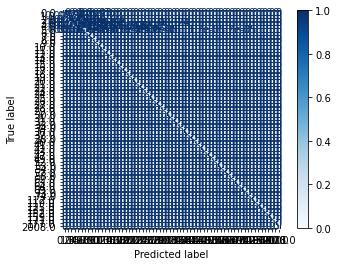


Validation Set
Accuracy: 0.5748

              precision    recall  f1-score   support

         0.0     0.0545    0.1071    0.0723        28
         1.0     0.3315    0.5626    0.4172       759
         2.0     0.2094    0.3417    0.2596       641
         3.0     0.3166    0.3849    0.3474      1312
         4.0     0.3418    0.4587    0.3917      2845
         5.0     0.8581    0.6574    0.7445      9375
         6.0     0.0000    0.0000    0.0000         5
         7.0     0.0000    0.0000    0.0000         5
         8.0     0.0000    0.0000    0.0000         4
         9.0     0.0000    0.0000    0.0000         1
        10.0     0.0000    0.0000    0.0000         5
        11.0     0.0000    0.0000    0.0000         4
        12.0     0.0000    0.0000    0.0000         1
        13.0     0.0000    0.0000    0.0000         2
        14.0     0.0000    0.0000    0.0000         1
        16.0     0.0000    0.0000    0.0000         1
        17.0     0.0000    0.0000    0.0000    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

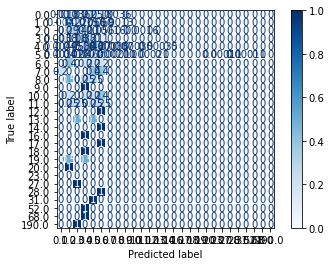


Testing Set
Accuracy: 0.5748

              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        31
         1.0     0.3018    0.5506    0.3899       712
         2.0     0.1937    0.3187    0.2409       615
         3.0     0.2824    0.3664    0.3190      1261
         4.0     0.3407    0.4415    0.3846      2847
         5.0     0.8645    0.6665    0.7527      9475
         6.0     0.0000    0.0000    0.0000         5
         7.0     0.0000    0.0000    0.0000         7
         8.0     0.0000    0.0000    0.0000         3
         9.0     0.0000    0.0000    0.0000         7
        10.0     0.0000    0.0000    0.0000         4
        11.0     0.0000    0.0000    0.0000         2
        12.0     0.0000    0.0000    0.0000         4
        13.0     0.0000    0.0000    0.0000         2
        14.0     0.0000    0.0000    0.0000         2
        16.0     0.0000    0.0000    0.0000         1
        18.0     0.0000    0.0000    0.0000       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py

In [ ]:
evaluate_model(clf_lr, model_name="lr")

In [ ]:
del clf_lr

#### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=500,
                                criterion="gini",
                                max_depth=None, 
                                min_samples_split=2,
                                min_samples_leaf=10, 
                                max_features="auto", 
                                n_jobs=-1,
                                verbose=1,
                                random_state=0,
                                class_weight='balanced')

In [ ]:
clf_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished


RandomForestClassifier(class_weight='balanced', min_samples_leaf=10,
                       n_estimators=500, n_jobs=-1, random_state=0, verbose=1)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    9.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   22.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   25.5s finished


Training Set
Accuracy: 0.6266216567125422

              precision    recall  f1-score   support

         0.0     0.6647    0.9784    0.7916       231
         1.0     0.4384    0.7829    0.5620      4633
         2.0     0.4061    0.7214    0.5196      4239
         3.0     0.5219    0.5951    0.5561      8367
         4.0     0.3974    0.5378    0.4571     18323
         5.0     0.8517    0.6358    0.7281     60124
         6.0     0.6769    1.0000    0.8073        44
         7.0     0.7000    1.0000    0.8235        42
         8.0     0.9062    1.0000    0.9508        29
         9.0     0.9545    1.0000    0.9767        21
        10.0     0.9545    1.0000    0.9767        21
        11.0     0.1707    1.0000    0.2917        21
        12.0     0.5333    1.0000    0.6957        16
        13.0     0.3889    1.0000    0.5600        14
        14.0     1.0000    1.0000    1.0000         7
        15.0     0.5909    1.0000    0.7429        13
        16.0     1.0000    1.0000    1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    9.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   22.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   25.3s finished


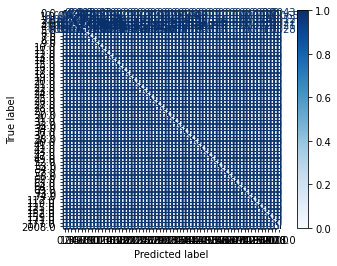

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    3.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metric

Validation Set
Accuracy: 0.5330666666666667

              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        28
         1.0     0.2934    0.4545    0.3566       759
         2.0     0.1819    0.3697    0.2438       641
         3.0     0.2680    0.2950    0.2808      1312
         4.0     0.3123    0.4313    0.3623      2845
         5.0     0.8252    0.6187    0.7071      9375
         6.0     0.0000    0.0000    0.0000         5
         7.0     0.0000    0.0000    0.0000         5
         8.0     0.0000    0.0000    0.0000         4
         9.0     0.0000    0.0000    0.0000         1
        10.0     0.0000    0.0000    0.0000         5
        11.0     0.0000    0.0000    0.0000         4
        12.0     0.0000    0.0000    0.0000         1
        13.0     0.0000    0.0000    0.0000         2
        14.0     0.0000    0.0000    0.0000         1
        16.0     0.0000    0.0000    0.0000         1
        17.0     0.0000    0.0000   

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    3.7s finished


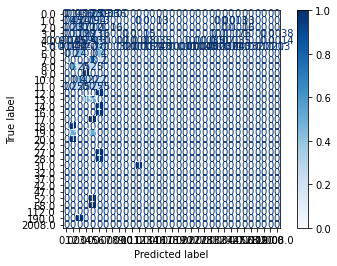

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    3.8s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metric

Testing Set
Accuracy: 0.5337333333333333

              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        31
         1.0     0.2680    0.4649    0.3400       712
         2.0     0.1518    0.3187    0.2057       615
         3.0     0.2607    0.2958    0.2771      1261
         4.0     0.3132    0.4208    0.3591      2847
         5.0     0.8333    0.6235    0.7133      9475
         6.0     0.0000    0.0000    0.0000         5
         7.0     0.0000    0.0000    0.0000         7
         8.0     0.0000    0.0000    0.0000         3
         9.0     0.0000    0.0000    0.0000         7
        10.0     0.0000    0.0000    0.0000         4
        11.0     0.0000    0.0000    0.0000         2
        12.0     0.0000    0.0000    0.0000         4
        13.0     0.0000    0.0000    0.0000         2
        14.0     0.0000    0.0000    0.0000         2
        15.0     0.0000    0.0000    0.0000         0
        16.0     0.0000    0.0000    0.

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    3.8s finished


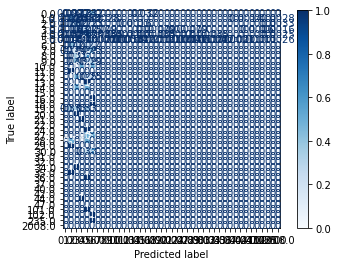

In [ ]:
evaluate_model(clf_rf, model_name="rf")

In [ ]:
del clf_rf

10: 0.611916

20: 0.616532

30: 0.617348

35: 0.617388

40: 0.616676